# Cell label transfer
The input for scVQC requires preprocessing. RNA-Seq counts should be normalized by scaling each cell's total count to 10,000, followed by a log(x+1) transformation. While scVQC can be applied to all genes in the dataset, we recommend focusing on highly variable genes (HVGs) for optimal results. In this study, we selected the top 3,000 HVGs for analysis. For detail, we followed the tutorial from the [the scanpy "Preprocessing and clustering" tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html) for preprocessing pipeline.

In [1]:
import os
import sys
sys.path.append("code/")

import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import umap.plot
from sklearn import metrics

from data_loader import *
from feature_spectrum import *
from model import *
from model_utils import set_seed
from train import *
set_seed(123)

/home/yusri/Programs/miniforge3/envs/vqvae/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yusri/Programs/miniforge3/envs/vqvae/lib/python3.9/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/yusri/Programs/miniforge3/envs/vqvae/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/yusri/Program

# Load data and set hyperparameters

In [2]:
dataset_path = "data/pancreas_3khvg_split_train.h5ad"
train_dataset = sc.read_h5ad(dataset_path)
# train_dataset = train_dataset[:, train_dataset.var["highly_variable"]]




fname = os.path.splitext(os.path.basename(dataset_path))[0]

# We use default parameter here
target = "cell_type" # The name of the column containing the cell type to be predicted.
batch_size = 32
hidden_dim1 = 1024
hidden_dim2 = 256
num_embeddings = 200
embedding_dim = 100
split = 20
commitment_cost = 0.25
device = "cuda"
learning_rate = 5e-4
n_epochs = 5
lr_weight_decay = 1e-6
verbose = True
fsq=False  # If fsq is set to True, FSQ is used as the quantizer. FSQ is an experimental method, and we recommend setting it to False.
levels=None # The hyperparameter for fsq. Ignored if fsq=False
ema = True
decay = 0.99
epsilon = 1e-5
dropout = 0.1
supervised = True # Make sure supervised=True. If it set to False, it will revert to VQ-VAE

In [3]:
# Conver anndata to custom Dataset class
train_set = GeneDataset(train_dataset, target=target)


In [4]:
if supervised:
    assert (
        train_set.target is not None
    ), "The target variable in the train set should be not empty"
    n_class = len(np.unique(train_set.labels))
else:
    n_class = None
n_class

14

# Train the classifier

In [5]:
%%time
(
    model,
    train_res_prediction_error,
    train_res_vq_loss,
    train_res_total_loss,
    train_res_perplexity,
) = train(
    train_set,
    supervised=supervised,
    n_class=n_class,
    batch_size=batch_size,
    device=device,
    learning_rate=learning_rate,
    n_epochs=n_epochs,
    lr_weight_decay=lr_weight_decay,
    hidden_dim1=hidden_dim1,
    hidden_dim2=hidden_dim2,
    num_embeddings=num_embeddings,
    embedding_dim=embedding_dim,
    commitment_cost=commitment_cost,
    verbose=verbose,
    split=split,
    fsq=fsq,
    levels=levels,
    ema=ema,
    decay=decay,
    epsilon=epsilon,
    dropout=dropout,
)

500 iterations
prediction_loss: 0.19804
vq_loss: 0.12381
perplexity: 8.60741
1000 iterations
prediction_loss: 0.03345
vq_loss: 0.02797
perplexity: 88.16394
1500 iterations
prediction_loss: 0.01564
vq_loss: 0.01691
perplexity: 133.51682
Finished VQ-VAE training
CPU times: user 12.8 s, sys: 599 ms, total: 13.4 s
Wall time: 11 s


## If you want to save the model, uncomment the code bellow

In [6]:
# model_info = "{}_ema:{}_supervised:{}_encoder:({}-{}-{})_num_codes:{}_split:{}_commitment_cost:{}_n_epochs:{}_lr:{}".format(
#     fname,
#     ema,
#     supervised,
#     hidden_dim1,
#     hidden_dim2,
#     embedding_dim,
#     num_embeddings,
#     split,
#     commitment_cost,
#     n_epochs,
#     learning_rate,
# )
# data_dir = model_info
# 
# if not os.path.exists(data_dir):
#     os.makedirs(data_dir)

# model_save_path = data_dir + "/model_" + model_info + ".pt"
# print("Save mode in: " + model_save_path)
# torch.save(model.state_dict(), model_save_path)

# Prediction
Use the predict function to obtain the log probabilities of the predictions. The highest log probability indicates the most likely cell type.

In [7]:
test_dataset_path = "data/pancreas_3khvg_split_test.h5ad"
test_dataset = sc.read_h5ad(test_dataset_path)
test_set = GeneDataset(test_dataset, target=target)

In [8]:
with torch.no_grad():
    model.eval()
    model_prediction = model.predict(test_set.genes.to(device))
    model_prediction = torch.argmax(model_prediction, axis=1).detach().cpu().numpy() # Get the highest probability
    acc = metrics.accuracy_score(test_set.labels, model_prediction)
    print(f"The accuracy for test set: {acc:.4f}")

The accuracy for test set: 0.9820


# Visualization of cell embedding

In [9]:
X_train= train_dataset.X
if scipy.sparse.issparse(X_train):
        X_train = X_train.toarray()
with torch.no_grad():
    model.eval()
    # Embed function will extract the continuous embedding, discrete embedding, and the index of the codes that is used in discrete embedding
    z_embedding, quantized_embedding, encoding_indices = model.embed(
            torch.tensor(X_train, dtype=torch.float32).to(device)
        )
    # We only need the discrete embedding
    train_dataset.obsm["X_emb_quantized"] = quantized_embedding.detach().cpu().numpy()
    # Encoding indices needed for creating feature spectrum
    train_dataset.obsm["encoding_indices"] = encoding_indices.detach().cpu().numpy()

In [10]:
use_rep = "X_emb_quantized"
sc.pp.neighbors(train_dataset,use_rep=use_rep)
sc.tl.leiden(train_dataset, flavor="igraph", resolution= 0.5, n_iterations=2)
sc.tl.umap(train_dataset,min_dist=0.1)

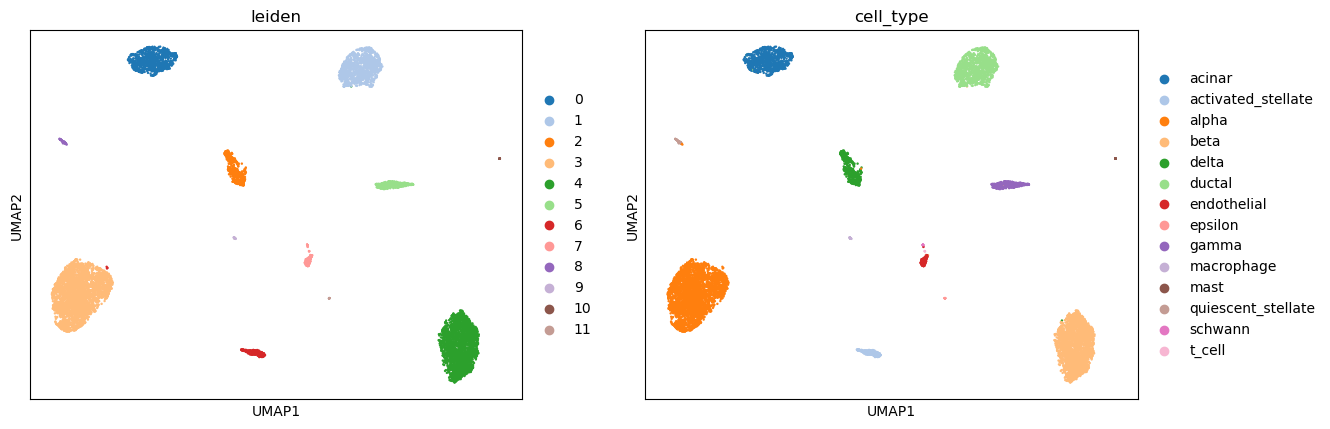

In [11]:
sc.pl.umap(train_dataset,color=["leiden", "cell_type"])

# Visualization of feature spectrum

In [12]:
labels = train_dataset.obs['cell_type'].cat.codes
feature_spectrum = cal_feat_spe(train_dataset.obsm["encoding_indices"],labels)

Feature spectrum shape:  (14, 200)


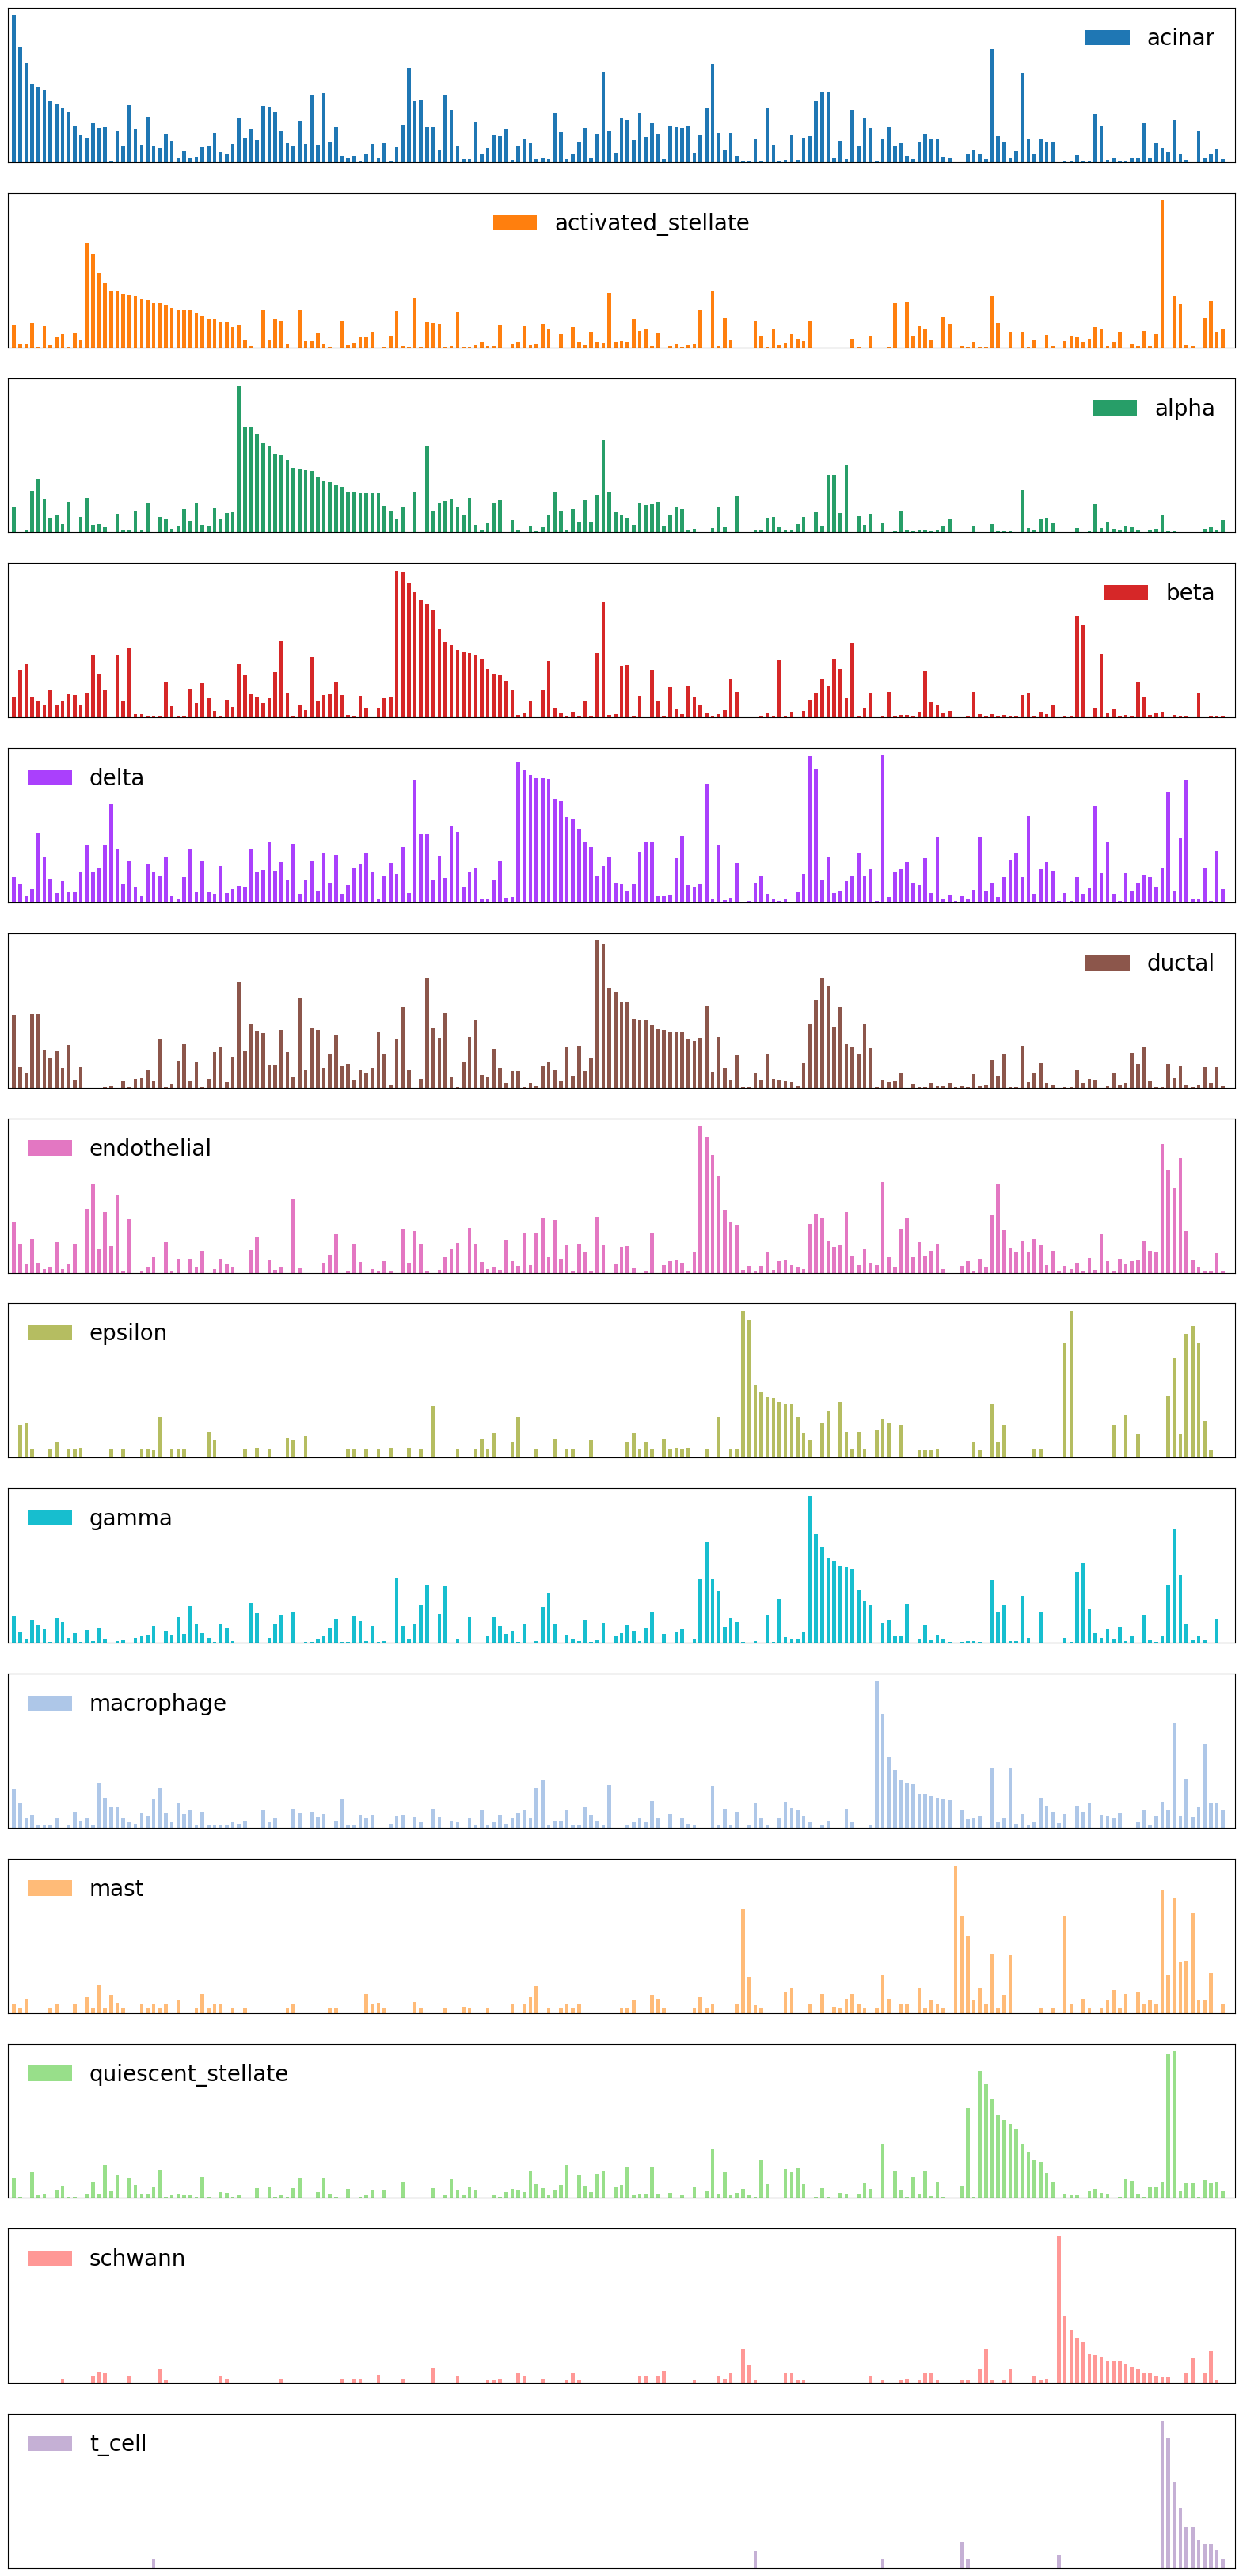

In [13]:
n_index = int(np.max(train_dataset.obsm["encoding_indices"]+1))

n_class= len(np.unique(train_dataset.obs['cell_type'].cat.codes))

colors = ['#1f77b4','#ff7f0e','#279e68','#d62728','#aa40fc','#8c564b','#e377c2','#b5bd61','#17becf','#aec7e8',
          '#ffbb78','#98df8a','#ff9896','#c5b0d5','#c49c94','#f7b6d2','#dbdb8d','#9edae5','#ad494a','#8c6d31']
f,axs = plt.subplots(nrows=n_class,ncols=1,figsize=(20, 3*n_class),sharex=True)
for i in np.unique(train_dataset.obs['cell_type'].cat.codes):
    ax=axs[i]
    cell_type = train_dataset.obs['cell_type'].cat.categories[i]
    ylim = np.max(feature_spectrum[i])
    ax.bar(np.arange(n_index), feature_spectrum[i], width=0.6, color=colors[i], label=cell_type)
    ax.tick_params(axis='both',          
    which='both',      
    bottom=False,      
    left=False,         
    labelbottom=False,
    labelleft =False)
    ax.set_xlim([-1,n_index+1])
    ax.legend(fontsize=20, frameon=False)

# f.savefig("./feature_spectrum.eps",bbox_inches="tight")
# f.savefig("./feature_spectrum.pdf",bbox_inches="tight")